# FB2NEP Workbook 2 – Populations, Samples, and Representativeness

This workbook introduces core ideas in sampling for nutritional epidemiology:

- The distinction between the **general population**, a **study's target population**, and the realised **sample**.
- The notions of **sampling frames**, **representativeness**, and **sampling error** versus **bias**.
- How a **probability sample** such as NHANES can be used as a reference for population structure.
- How to compare simple descriptive statistics between a **reference population** (NHANES) and a **study cohort** (the FB2NEP synthetic dataset).
- How **sample size** affects the precision of estimates of central tendency (here: body mass index, BMI).

We use two datasets:

- **NHANES (National Health and Nutrition Examination Survey)**: a large, nationally representative survey of the non-institutionalised United States population. Here we download a small subset of NHANES 2017–2018 directly from the [CDC website](https://www.cdc.gov) via a helper script.
- **FB2NEP synthetic cohort**: the synthetic dataset that we use throughout the module for regression and causal reasoning. Here it plays the role of a *study sample* that we compare to NHANES.

> Hippo cameo: imagine a very diligent hippo who always volunteers for nutrition surveys. This will help us think about who actually ends up in a sample.


In [1]:
# Bootstrap the FB2NEP repository (works in Colab and locally).
#
# This cell:
# - Clones the fb2nep-epi repository in Google Colab if needed.
# - Locates and runs scripts/bootstrap.py.
# - Ensures that data/ and notebooks/ are available.

import os
import sys
import runpy
import pathlib
import subprocess

REPO_URL = "https://github.com/ggkuhnle/fb2nep-epi.git"
REPO_NAME = "fb2nep-epi"

# 1. If we are in Colab and scripts/bootstrap.py is not present,
#    clone the repository and change into it.
if "google.colab" in sys.modules and not pathlib.Path("scripts/bootstrap.py").exists():
    root = pathlib.Path("/content")
    repo_dir = root / REPO_NAME

    if not repo_dir.exists():
        print(f"Cloning {REPO_URL} …")
        subprocess.run(["git", "clone", REPO_URL], check=True)

    os.chdir(repo_dir)
    print("Changed working directory to:", os.getcwd())

# 2. Now try to locate and run scripts/bootstrap.py
for p in ["scripts/bootstrap.py", "../scripts/bootstrap.py", "../../scripts/bootstrap.py"]:
    if pathlib.Path(p).exists():
        print(f"Bootstrapping via: {p}")
        runpy.run_path(p)
        break
else:
    print("⚠️ scripts/bootstrap.py not found – "
          "please check that the FB2NEP repository is available.")


Bootstrapping via: ../scripts/bootstrap.py


In [ ]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Ensure the repository root (which contains 'scripts/') is on sys.path
# ---------------------------------------------------------------------
# We try the current directory, its parent, and the grandparent.
# The first one that has scripts/fetch_nhanes_demo.py is treated as root.
candidate_roots = [
    pathlib.Path(".").resolve(),
    pathlib.Path("..").resolve(),
    pathlib.Path("../..").resolve(),
]

repo_root = None
for root in candidate_roots:
    if (root / "scripts" / "fetch_nhanes_demo.py").exists():
        repo_root = root
        break

if repo_root is None:
    raise FileNotFoundError(
        "Could not find the repository root containing 'scripts/fetch_nhanes_demo.py'. "
        "Please check that you are running this notebook inside the fb2nep-epi project."
    )

# Add the repository root to the Python import path (if not already present)
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

print("Using repository root:", repo_root)

from scripts.fetch_nhanes_demo import load_nhanes_demo

# ---------------------------------------------------------------------
# Fixed random seed for all simulations in this workbook.
# ---------------------------------------------------------------------
RANDOM_SEED = 11088
rng = np.random.default_rng(RANDOM_SEED)

# Load processed NHANES subset (downloaded and tidied by helper script).
nhanes = load_nhanes_demo(cache=True)

# Load the FB2NEP synthetic cohort used throughout the module.
df_fb2nep = pd.read_csv("../data/synthetic/fb2nep.csv")

print("NHANES demo shape:", nhanes.shape)
print("FB2NEP synthetic cohort shape:", df_fb2nep.shape)

nhanes.head()


Using repository root: /Users/gunter/Documents/fb2nep-epi
Loading NHANES demo from cache: data/private/nhanes_demo_2017_2018.csv
NHANES demo shape: (5569, 6)
FB2NEP synthetic cohort shape: (25000, 27)


,SEQN,age_years,sex,race_eth,education,bmi
0,93705.0,66.0,Female,Black,≤High school,31.7
1,93708.0,66.0,Female,Asian,≤High school,23.7
2,93709.0,75.0,Female,Black,Some college,38.9
3,93711.0,56.0,Male,Asian,College+,21.3
4,93713.0,67.0,Male,White,≤High school,23.5


## 1. Concepts and definitions

### 1.1 General population, target population, and sample

- **General population**: The entire group about which we ultimately wish to draw conclusions. Examples: “all adults living in the United States”, or “all adults aged 40 years and older in the United Kingdom”.

- **Target population (study population)**: The subset of the general population that a particular study *intends* to represent. Examples: <font color='red'>all adults aged 40–79 years registered with a general practitioner in England</font>, or <font color='red'>all post-menopausal women without prior cardiovascular disease at baseline</font>>. This definition is conceptual and exists **before** sampling.

- **Sampling frame**: The operational list or mechanism used to select individuals. Examples: general practice registers, electoral rolls, health insurance lists, employee registers. Individuals who are not in the sampling frame cannot be selected, even if they belong to the target population.

- **Sample**: The actual set of individuals who are recruited and provide data. The sample may differ from the target population because of non-response, exclusion criteria, and practical constraints.

Key questions for any study: 

1. **Who did we intend to study?** (target population)
2. **Who did we actually study?** (realised sample)
3. **How different are these groups** with respect to variables that matter for our research question?


### 1.2 Representativeness, sampling error, and bias

A sample is **representative** of a population when the distribution of key characteristics in the sample matches that of the population of interest. Common characteristics:

- Sex.
- Age distribution.
- Socioeconomic position (for example, education, deprivation indices).
- Ethnicity (if available).

Representativeness is mainly about **external validity**: how far we can generalise study findings beyond those who took part.

It is useful to distinguish two sources of difference between sample and population:

- **Sampling error**: Random variation in estimates because we observe only a finite sample rather than the whole population. Sampling error becomes smaller as the sample size increases.
- **Systematic bias**: Systematic differences between sample and population (for example, non-participation of people with poor health or low income) that do **not** disappear when the sample size increases.

In this workbook we will:

- Use **NHANES** as a reference survey for the general population.
- Treat the **FB2NEP synthetic cohort** as a “study sample” and compare it to NHANES.
- Use repeated sampling from NHANES to illustrate **sampling error**.


### 1.3 NHANES and the FB2NEP synthetic cohort

- **NHANES** 🇺🇸 uses complex probability sampling strategies to obtain an approximately nationally representative sample of the civilian, non-institutionalised United States population. For this workbook we focus on adults and use a limited set of variables: age, sex, race/ethnicity, education, and BMI.

- The **FB2NEP synthetic cohort** is a simulated cohort used for teaching. It mimics a longitudinal study of adults aged 40 years and older with follow-up for cardiovascular disease and cancer. It is not designed to be representative of any real country, but we can still compare its structure to NHANES.


In [9]:
# Quick look at the FB2NEP synthetic cohort.

    
fb_cols = [
    "id", "age", "sex", "IMD_quintile", "SES_class", "BMI", "SBP",
    "fruit_veg_g_d", "red_meat_g_d", "CVD_incident", "Cancer_incident"
]

# Use list comprehension to keep only columns that are actually present.
fb_cols = [c for c in fb_cols if c in df_fb2nep.columns]

df_fb2nep[fb_cols].head()

,id,age,sex,IMD_quintile,SES_class,BMI,SBP,fruit_veg_g_d,red_meat_g_d,CVD_incident,Cancer_incident
0,1,59,M,5,ABC1,34.2,NaN,361.2,69.3,1,1
1,2,60,M,4,ABC1,30.5,169.4,191.5,113.8,0,0
2,3,54,F,4,ABC1,28.7,136.4,337.1,0.0,0,0
3,4,67,F,3,ABC1,32.1,153.6,88.2,80.3,0,0
4,5,70,M,1,C2DE,27.5,173.3,169.6,144.8,0,0


## 2. Basic distributions in NHANES

We first inspect the distribution of sex, age, and race/ethnicity in the NHANES subset. We create simple age groups for adults and compute proportion tables.


In [10]:
# Create age groups for NHANES adults.
#
# We restrict to adults aged 20 years and older (already done in the helper script),
# and group into: 20–39, 40–59, 60+ years.

age_bins_nhanes = [20, 40, 60, np.inf]
age_labels_nhanes = ["20–39", "40–59", "60+"]

nhanes = nhanes.copy()
nhanes["age_group"] = pd.cut(
    nhanes["age_years"],
    bins=age_bins_nhanes,
    labels=age_labels_nhanes,
    right=False,
)

nhanes[["age_years", "age_group", "sex", "race_eth", "education", "bmi"]].head()

,age_years,age_group,sex,race_eth,education,bmi
0,66.0,60+,Female,Black,≤High school,31.7
1,66.0,60+,Female,Asian,≤High school,23.7
2,75.0,60+,Female,Black,Some college,38.9
3,56.0,40–59,Male,Asian,College+,21.3
4,67.0,60+,Male,White,≤High school,23.5


In [12]:
from scripts.helpers_tables import proportion_table

print("NHANES sex distribution:")
display(proportion_table(nhanes, "sex", dropna=False))

print("\nNHANES age group distribution:")
display(proportion_table(nhanes, "age_group", dropna=False))

print("\nNHANES race/ethnicity distribution:")
display(proportion_table(nhanes, "race_eth", dropna=False))

NHANES sex distribution:


,count,proportion
sex,,
Female,2867,0.514814
Male,2702,0.485186



NHANES age group distribution:


,count,proportion
age_group,,
60+,2150,0.386066
40–59,1732,0.311007
20–39,1687,0.302927



NHANES race/ethnicity distribution:


,count,proportion
race_eth,,
White,1935,0.347459
Black,1298,0.233076
Hispanic,1252,0.224816
Asian,811,0.145628
Other,273,0.049021


## 3. Representation relative to the United States Census

NHANES is designed to be approximately representative of the United States population. To illustrate this, we compare NHANES proportions to approximate adult distributions from the United States Census (values here are simplified for teaching).

We compute a **representation ratio** for each category:

\begin{equation}
\text{representation ratio} = \frac{\text{NHANES proportion}}{\text{Census proportion}}.
\end{equation}

- A value close to 1 means that NHANES has a similar proportion to the Census.
- Values greater than 1 indicate **over-representation** in NHANES.
- Values less than 1 indicate **under-representation**.


In [13]:
# Approximate United States Census distributions for adults.
# These values are illustrative and are not official statistics.

census_sex = pd.DataFrame({
    "sex": ["Female", "Male"],
    "census_prop": [0.509, 0.491],
})

census_age = pd.DataFrame({
    "age_group": ["20–39", "40–59", "60+"],
    "census_prop": [0.35, 0.33, 0.32],
})

census_race = pd.DataFrame({
    "race_eth": ["White", "Black", "Hispanic", "Asian", "Other"],
    "census_prop": [0.58, 0.12, 0.19, 0.06, 0.05],
})

census_sex

,sex,census_prop
0,Female,0.509
1,Male,0.491


In [14]:
from scripts.helpers_tables import representation_table


# Compute NHANES proportion tables.
nhanes_sex = proportion_table(nhanes, "sex").reset_index().rename(columns={"index": "sex"})
nhanes_age = proportion_table(nhanes, "age_group").reset_index().rename(columns={"index": "age_group"})
nhanes_race = proportion_table(nhanes, "race_eth").reset_index().rename(columns={"index": "race_eth"})

# Compute representation ratios.
repr_sex = representation_table(nhanes_sex, census_sex, "sex")
repr_age = representation_table(nhanes_age, census_age, "age_group")
repr_race = representation_table(nhanes_race, census_race, "race_eth")

repr_sex

,sex,count,sample_prop,census_prop,representation_ratio
0,Female,2867,0.514814,0.509,1.011423
1,Male,2702,0.485186,0.491,0.988159


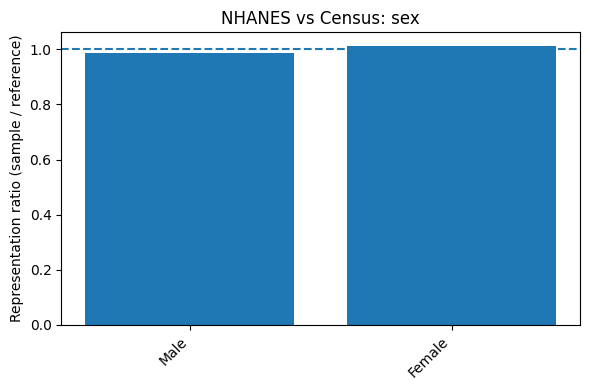

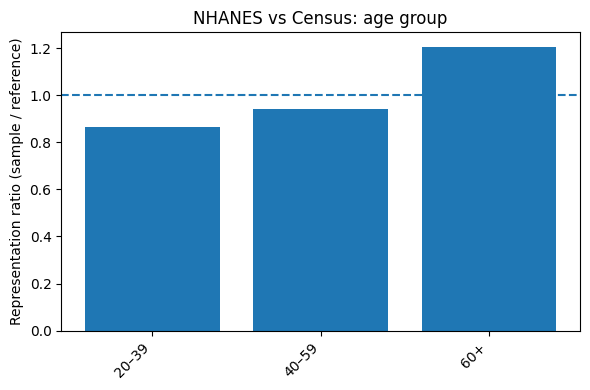

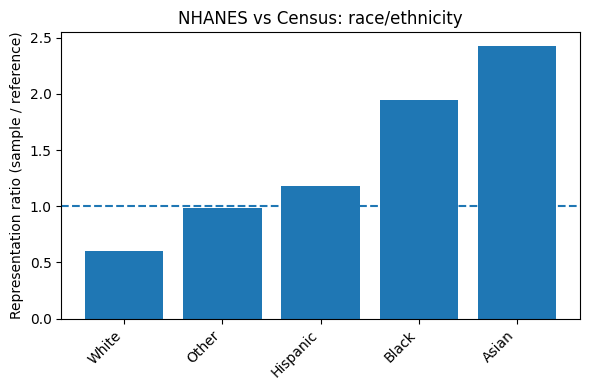

In [15]:
from scripts.helpers_tables import plot_representation

plot_representation(repr_sex, "sex", "NHANES vs Census: sex")
plot_representation(repr_age, "age_group", "NHANES vs Census: age group")
plot_representation(repr_race, "race_eth", "NHANES vs Census: race/ethnicity")

### Interpretation

- A representation ratio close to 1.0 indicates that NHANES has a similar proportion to the Census for that category.
- Ratios above 1.0 indicate that the category is **over-represented** in NHANES; ratios below 1.0 indicate **under-representation**.
- NHANES is designed to be reasonably close to the United States population, but it is not perfect. Some groups will be slightly over- or under-represented even after weighting.


## 4. Sampling variability and sample size (NHANES BMI example)

We now treat the NHANES subset as our **population** and examine how estimates of mean BMI vary when we repeatedly draw samples of different sizes.

For a numeric variable such as **BMI** we compute:

- The population mean and standard deviation using all NHANES adults.
- The distribution of **sample means** from many repeated samples of size *n*.

We expect that:

- The mean of the sample means will be close to the true population mean.
- The variability of the sample means will decrease as the sample size increases.


In [16]:
# Population statistics for BMI in NHANES.

if "bmi" not in nhanes.columns:
    raise KeyError("The NHANES dataset does not contain a 'bmi' column.")

pop_mean_bmi = nhanes["bmi"].mean()
pop_sd_bmi = nhanes["bmi"].std()

print("NHANES BMI (adults) – population statistics:")
print(f"  Mean: {pop_mean_bmi:5.2f}")
print(f"  SD:   {pop_sd_bmi:5.2f}")

NHANES BMI (adults) – population statistics:
  Mean: 29.85
  SD:    7.40


### 4.1 Setting up the simulation

We now *simulate* what would happen if we repeatedly carried out the same study many times on different random samples from the same population.

The goal is to understand the **sampling distribution of the mean BMI** for different sample sizes.

The key ideas are:

- We treat the NHANES dataset (`nhanes`) as if it were the **true population**.
- For each chosen sample size *n* (for example, 10, 50, 100, 500, 2 000), we:
  1. Draw a simple random sample of size *n* from NHANES (without replacement).
  2. Calculate the mean BMI in that sample.
  3. Repeat this process `n_sim` times (for example, 300 times).
- The resulting collection of mean BMI values shows how much the estimate of the mean BMI **varies from study to study**, purely due to random sampling.


In [23]:
from scripts.helpers_tables import draw_sample_mean_bmi, simulate_sampling_distribution

# Compute the "true" population mean BMI from the full NHANES dataset.
# In this workbook we treat NHANES as the population.
true_mean_bmi = float(nhanes["bmi"].mean().round(2))

print(f"True (population) mean BMI from NHANES: {true_mean_bmi:.2f}")

# Choose sample sizes for comparison and number of simulations.
sample_sizes = [10, 50, 100, 500, 2000]
n_sim = 300   # number of repeated samples for each n

# Dictionary to store the sampling distributions for each n
sampling_results = {}
for n in sample_sizes:
    sampling_results[n] = simulate_sampling_distribution(nhanes, n, n_sim, rng)

# Inspect the first few simulated means for n = 10
print("\nFirst five simulated sample means (n = 10):")
print(np.round(sampling_results[10][:5], 2))

# Compare the average of simulated means to the true mean
simulated_mean_10 = float(np.mean(sampling_results[10]).round(2))
print(f"\nAverage of simulated means for n = 10: {simulated_mean_10:.2f}")
print(f"Difference from true mean: {simulated_mean_10 - true_mean_bmi:+.2f}")


# Inspect the first few simulated means for n = 500
print("\nFirst five simulated sample means (n = 500):")
print(np.round(sampling_results[500][:5], 2))

# Compare the average of simulated means to the true mean
simulated_mean_500 = float(np.mean(sampling_results[500]).round(2))
print(f"\nAverage of simulated means for n = 500: {simulated_mean_500:.2f}")
print(f"Difference from true mean: {simulated_mean_500 - true_mean_bmi:+.2f}")


True (population) mean BMI from NHANES: 29.85

First five simulated sample means (n = 10):
[31.66 27.44 31.41 31.91 29.94]

Average of simulated means for n = 10: 29.89
Difference from true mean: +0.04

First five simulated sample means (n = 500):
[30.1  30.67 29.64 30.1  29.42]

Average of simulated means for n = 500: 29.89
Difference from true mean: +0.04


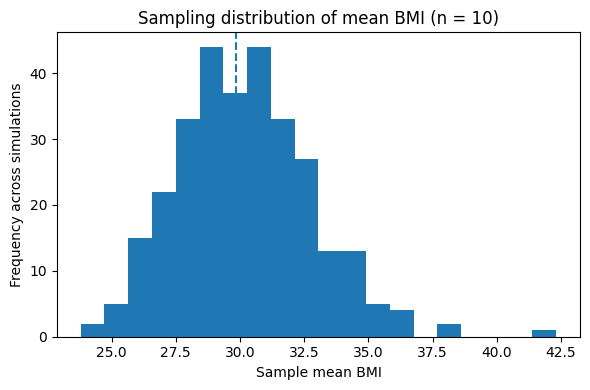

n = 10
  Mean of sample means: 30.190
  SD of sample means:    2.628
  Population mean BMI:  29.852



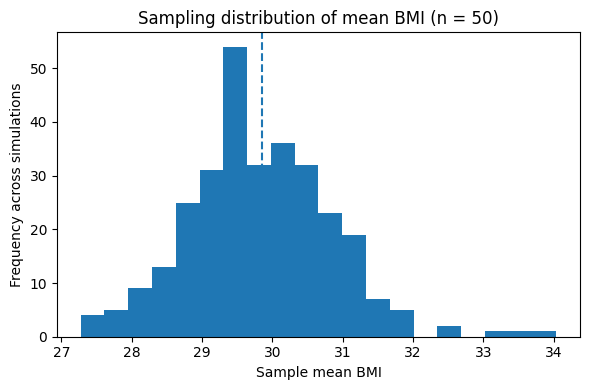

n = 50
  Mean of sample means: 29.827
  SD of sample means:    1.021
  Population mean BMI:  29.852



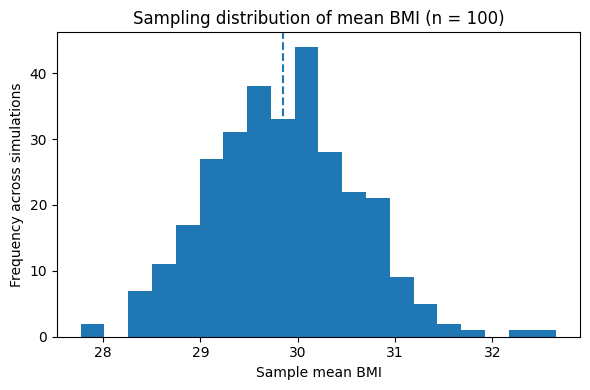

n = 100
  Mean of sample means: 29.845
  SD of sample means:    0.753
  Population mean BMI:  29.852



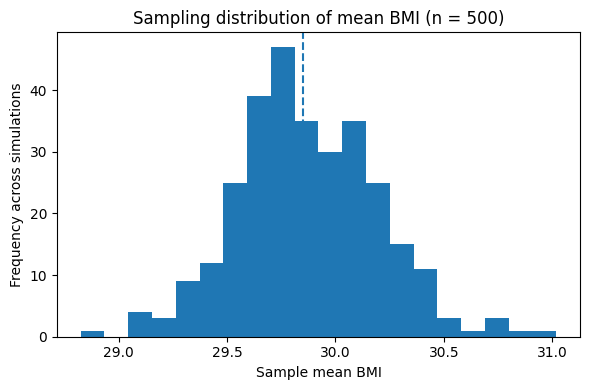

n = 500
  Mean of sample means: 29.871
  SD of sample means:    0.328
  Population mean BMI:  29.852



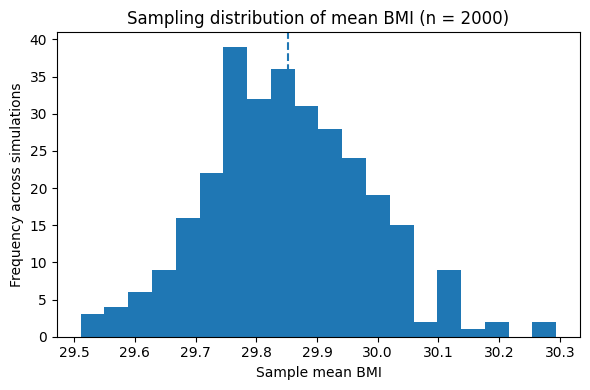

n = 2000
  Mean of sample means: 29.851
  SD of sample means:    0.134
  Population mean BMI:  29.852



In [22]:
# Plot histograms of sample means for each sample size.

for n in sample_sizes:
    means = sampling_results[n]

    plt.figure(figsize=(6, 4))
    plt.hist(means, bins=20)
    plt.axvline(pop_mean_bmi, linestyle="--")
    plt.xlabel("Sample mean BMI")
    plt.ylabel("Frequency across simulations")
    plt.title(f"Sampling distribution of mean BMI (n = {n})")
    plt.tight_layout()
    plt.show()

    print(f"n = {n}")
    print(f"  Mean of sample means: {means.mean():6.3f}")
    print(f"  SD of sample means:   {means.std():6.3f}")
    print(f"  Population mean BMI:  {pop_mean_bmi:6.3f}\n")

### Interpretation

- The **centre** of each sampling distribution (mean of the sample means) is close to the true NHANES mean BMI.
- The **spread** of the sampling distribution (standard deviation of the sample means) decreases as the sample size increases.
- The reduction in spread is approximately proportional to **1/√n**, which is the basis for many ideas in statistical inference (for example, standard errors and confidence intervals).


## 5. Comparing the FB2NEP synthetic cohort to NHANES

We now compare the **structure** of the FB2NEP synthetic cohort to the NHANES reference survey. The aim is not to make the synthetic cohort “representative of the United States”, but to illustrate how one might compare a study sample to a reference population.

Because the FB2NEP cohort includes only adults aged 40 years and older, we first create a matching subset of NHANES adults aged 40 years and older.


In [24]:
# Restrict NHANES to adults aged 40+ years and define age groups.

nhanes_40plus = nhanes[nhanes["age_years"] >= 40].copy()

age_bins_40 = [40, 55, 70, np.inf]
age_labels_40 = ["40–54", "55–69", "70+"]

nhanes_40plus["age_group_40"] = pd.cut(
    nhanes_40plus["age_years"],
    bins=age_bins_40,
    labels=age_labels_40,
    right=False,
)

# Define equivalent age groups in the FB2NEP cohort.
df_fb2nep = df_fb2nep.copy()
df_fb2nep["age_group_40"] = pd.cut(
    df_fb2nep["age"],
    bins=age_bins_40,
    labels=age_labels_40,
    right=False,
)

nhanes_40plus[["age_years", "age_group_40", "sex"]].head()

,age_years,age_group_40,sex
0,66.0,55–69,Female
1,66.0,55–69,Female
2,75.0,70+,Female
3,56.0,55–69,Male
4,67.0,55–69,Male


In [25]:
from scripts.helpers_tables import compare_two_sources



print("Sex distribution: NHANES 40+ vs FB2NEP synthetic cohort")
display(compare_two_sources(nhanes_40plus, df_fb2nep, "sex", "NHANES40", "FB2NEP"))

print("\nAge group (40+): NHANES vs FB2NEP synthetic cohort")
display(compare_two_sources(nhanes_40plus, df_fb2nep, "age_group_40", "NHANES40", "FB2NEP"))

Sex distribution: NHANES 40+ vs FB2NEP synthetic cohort


,NHANES40_count,NHANES40_prop,FB2NEP_count,FB2NEP_prop
sex,,,,
F,NaN,NaN,13054.0,0.52216
Female,1980.0,0.510046,NaN,NaN
M,NaN,NaN,11946.0,0.47784
Male,1902.0,0.489954,NaN,NaN



Age group (40+): NHANES vs FB2NEP synthetic cohort


,NHANES40_count,NHANES40_prop,FB2NEP_count,FB2NEP_prop
age_group_40,,,,
40–54,1243,0.320196,9140,0.36560
55–69,1593,0.410355,12711,0.50844
70+,1046,0.269449,3149,0.12596


### 7.1 Coding differences: `sex` in NHANES vs FB2NEP

> What is going on here? NHANES and FB2NEP code `sex` differently!  
> NHANES uses `"Female"` / `"Male"`, whereas FB2NEP uses `"F"` / `"M"`.

This is a simple but important example of a **coding problem**:

- The two datasets refer to the **same underlying concept** (biological sex at baseline),
- but they use **different labels** for the categories.

If we tabulate or merge without harmonising the codes, we obtain misleading tables:

- Four rows (`F`, `M`, `Female`, `Male`) instead of two,
- missing values in some of the columns because categories do not align.

This kind of problem occurs frequently when combining:

- different surveys,
- registry data and cohort data,
- different waves of the same study.

We now create a *harmonised* version of `sex` in both datasets, with the labels `"Female"` and `"Male"`, and then repeat the comparison.


In [ ]:
# -------------------------------------------
# Harmonise the coding of 'sex' in both sets
# -------------------------------------------

def harmonise_sex(series: pd.Series) -> pd.Series:
    """
    Map different encodings of sex to common labels "Female" / "Male".

    Parameters
    ----------
    series : pandas.Series
        Original sex variable (for example 'F'/'M' or 'Female'/'Male').

    Returns
    -------
    pandas.Series
        New series with values "Female" or "Male" (or NaN if unknown).

    Notes
    -----
    - Any unexpected categories are printed so that they can be
      checked manually (for example 'Other', 'Prefer not to say').
    """
    # Define how original codes are to be translated.
    code_map = {
        "F": "Female",
        "M": "Male",
        "Female": "Female",
        "Male": "Male",
    }

    # Apply the mapping; entries not in code_map become NaN.
    mapped = series.map(code_map)

    # Identify any values that were not in the mapping.
    unknown = series[~series.isna() & mapped.isna()].unique()
    if len(unknown) > 0:
        print("Warning: unexpected categories in 'sex':", unknown)

    return mapped


# Apply the harmonisation to both datasets.
nhanes_40plus["sex_harmonised"] = harmonise_sex(nhanes_40plus["sex"])
df_fb2nep["sex_harmonised"] = harmonise_sex(df_fb2nep["sex"])

# Quick check: show the distribution in each dataset.
print("NHANES 40 Plus (harmonised):")
print(nhanes_40plus["sex_harmonised"].value_counts(dropna=False))
print("\nFB2NEP (harmonised):")
print(df_fb2nep["sex_harmonised"].value_counts(dropna=False))


NHANES (harmonised):
sex_harmonised
Female    1980
Male      1902
Name: count, dtype: int64

FB2NEP (harmonised):
sex_harmonised
Female    13054
Male      11946
Name: count, dtype: int64


Let's repeat the code above:

In [29]:

print("Sex distribution: NHANES 40+ vs FB2NEP synthetic cohort")
display(compare_two_sources(nhanes_40plus, df_fb2nep, "sex_harmonised", "NHANES40", "FB2NEP"))

print("\nAge group (40+): NHANES vs FB2NEP synthetic cohort")
display(compare_two_sources(nhanes_40plus, df_fb2nep, "age_group_40", "NHANES40", "FB2NEP"))

Sex distribution: NHANES 40+ vs FB2NEP synthetic cohort


,NHANES40_count,NHANES40_prop,FB2NEP_count,FB2NEP_prop
sex_harmonised,,,,
Female,1980,0.510046,13054,0.52216
Male,1902,0.489954,11946,0.47784



Age group (40+): NHANES vs FB2NEP synthetic cohort


,NHANES40_count,NHANES40_prop,FB2NEP_count,FB2NEP_prop
age_group_40,,,,
40–54,1243,0.320196,9140,0.36560
55–69,1593,0.410355,12711,0.50844
70+,1046,0.269449,3149,0.12596


> **Hippo cameo:** imagine that exactly one extremely diligent hippo lives in the catchment
> area and always volunteers for every nutrition study. The hippo will appear in many study
> samples, but this single observation tells us little about the many hippos who do not
> volunteer. This is an example of how selection can be systematic rather than random.


### Interpretation

- The FB2NEP synthetic cohort is not intended to match NHANES exactly, but it is still useful to compare basic characteristics such as sex and age distribution.
- If a real study sample differs strongly from a reference survey (such as NHANES or NDNS), then the study may have limited **external validity** for the general population.
- The comparison does not by itself prove bias in associations, but it is an important step in describing **who we are studying**.


### 7.2 Additional variables for representativeness: SES vs education

We may wish to compare other characteristics between NHANES and the FB2NEP synthetic cohort, for example:

- `education` in NHANES (for example, “≤High school”, “Some college”, “Bachelor+”), and  
- `SES_class` in FB2NEP (for example, “ABC1”, “C2DE”).

Both variables describe aspects of **socioeconomic position**, but they are **not the same**:

- `education` is an individual-level measure of highest qualification;
- `SES_class` in FB2NEP is a social grade based on occupation (ABC1 vs C2DE).

Direct comparison of the original categories is therefore not meaningful. Instead, we can:

1. Inspect the category labels and distributions in each dataset.
2. Construct a **very crude harmonised variable** that groups people into “lower” and “higher” socioeconomic position.
3. Compare these simplified variables, while being explicit about the approximation.

This illustrates that harmonisation often involves judgement and information loss. In real analyses, this should be documented and justified.


In [31]:
from scripts.helpers_tables import compare_two_sources

# -------------------------------------------------
# Step 1: inspect the original SES / education codes
# -------------------------------------------------

print("NHANES 'education' categories:")
print(nhanes["education"].value_counts(dropna=False))
print("\nFB2NEP 'SES_class' categories:")
print(df_fb2nep["SES_class"].value_counts(dropna=False))

# -------------------------------------------------
# Step 2: create a very crude harmonised SEP variable
# -------------------------------------------------
# For teaching purposes we define:
#
#   - In NHANES (education):
#       "≤High school"  -> "lower"
#       "Some college"  -> "middle"
#       "Bachelor+"     -> "higher"
#
#   - In FB2NEP (SES_class):
#       "C2DE"          -> "lower"
#       "ABC1"          -> "higher"
#
# We then collapse to a simple "lower" vs "higher_or_middle" binary
# variable in both datasets, so that we can compare something roughly
# analogous across the two sources.
#
# This is deliberately crude and should be interpreted with caution.

def make_sep_binary_from_education(education: pd.Series) -> pd.Series:
    """
    Convert NHANES education categories into a crude binary SEP measure.

    Returns "lower" or "higher_or_middle". Explicit "Unknown" values
    are treated as missing (NaN). Any truly unexpected categories are
    reported.
    """
    # First treat the NHANES label "Unknown" as missing.
    education_clean = education.replace("Unknown", pd.NA)

    # Map the remaining education categories to a simplified SEP measure.
    edu_map = {
        "≤High school": "lower",
        "Some college": "higher_or_middle",
        "College+": "higher_or_middle",   # corrected label
    }

    sep = education_clean.map(edu_map)

    # Identify any values that are not missing and were not mapped.
    unknown = education_clean[~education_clean.isna() & sep.isna()].unique()
    if len(unknown) > 0:
        print("Warning: unexpected education categories:", unknown)

    return sep


def make_sep_binary_from_ses_class(ses: pd.Series) -> pd.Series:
    """Convert FB2NEP SES_class into a crude binary SEP measure.

    Returns "lower" or "higher_or_middle".
    """
    # Create dictionary mapping SES to category
    

    ses_map = {
        "C2DE": "lower",
        "ABC1": "higher_or_middle",
    }

    sep = ses.map(ses_map)

    unknown = ses[~ses.isna() & sep.isna()].unique()
    if len(unknown) > 0:
        print("Warning: unexpected SES_class categories:", unknown)

    return sep


# Apply the mappings to create harmonised binary SEP variables.
nhanes["SEP_binary"] = make_sep_binary_from_education(nhanes["education"])
df_fb2nep["SEP_binary"] = make_sep_binary_from_ses_class(df_fb2nep["SES_class"])

print("\nNHANES SEP_binary:")
print(nhanes["SEP_binary"].value_counts(dropna=False))
print("\nFB2NEP SEP_binary:")
print(df_fb2nep["SEP_binary"].value_counts(dropna=False))

# -------------------------------------------------
# Step 3: compare the crude SEP distributions
# -------------------------------------------------

sep_comparison = compare_two_sources(
    ref=nhanes,
    study=df_fb2nep,
    column="SEP_binary",
    ref_label="NHANES40",
    study_label="FB2NEP",
)

sep_comparison


NHANES 'education' categories:
education
≤High school    2442
Some college    1778
College+        1336
Unknown           13
Name: count, dtype: int64

FB2NEP 'SES_class' categories:
SES_class
ABC1    13095
C2DE    11905
Name: count, dtype: int64

NHANES SEP_binary:
SEP_binary
higher_or_middle    3114
lower               2442
NaN                   13
Name: count, dtype: int64

FB2NEP SEP_binary:
SEP_binary
higher_or_middle    13095
lower               11905
Name: count, dtype: int64


,NHANES40_count,NHANES40_prop,FB2NEP_count,FB2NEP_prop
SEP_binary,,,,
higher_or_middle,3114,0.559167,13095.0,0.5238
lower,2442,0.438499,11905.0,0.4762
NaN,13,0.002334,NaN,NaN


## 8. Exercises

1. **Change the sample size in the BMI simulation**  
   In the sampling demonstration, add another sample size (for example, `n = 50` or `n = 5000`) to the `sample_sizes` list and rerun the simulation. How does the spread of the sample mean BMI change? Relate your findings to the idea that standard errors shrink with 1/√n.

2. **Alternative age groupings**  
   Define different age groupings (for example, two broad groups 40–64 and 65+) and repeat the comparison. How does the choice of grouping affect your impression of representativeness?

3. **Selection bias thought experiment**  
   Suppose that in a real cohort, people with very poor health are less likely to participate. Describe in a short paragraph how this could bias estimates of the association between physical activity and cardiovascular disease.

4. **Country-specific reference surveys**  
   In the United Kingdom, the **National Diet and Nutrition Survey (NDNS)** is often used as a reference for diet and some health indicators. Look up (outside this notebook) what NDNS is and which population it covers. How might you compare a United Kingdom cohort to NDNS in a similar way to what we have done here with NHANES?


## 9. Summary

- **Population, target population, and sample** are related but distinct concepts. It is essential to be explicit about each before analysing data.
- **Representativeness** concerns the similarity of the sample to the population of interest in terms of key characteristics and is closely linked to **external validity**.
- **Sampling error** arises because we observe only a finite sample. It decreases as the sample size increases but never disappears entirely.
- Using a reference survey such as **NHANES** allows us to compare the structure of a study sample (here: the FB2NEP synthetic cohort) to a broader population.
- Restricted or specialised cohorts can provide excellent information about associations **within** certain groups but are not automatically representative of all adults.
- Comparing your own data to reference surveys is a routine and important step in nutritional epidemiology, both for describing study populations and for assessing the generalisability of findings.
